# Dimension, Information, Dynamics, and Time Series

We measure the extraction of information and geometry from nonlinear systems over time in many ways. 

TODO: 
1) Datasets: time series datasets (logistic map, chaotic attractors), image datasets (MNIST), manifold (swiss roll with extra dimensions)
2) Embedding algos: takens (TS), PCA, MLP-AE, CNN-AE, Koopman-AE, etc.

Data Compression: 
1) measure I(X,X_comp), reconstruciton loss (MSE/NMSE), loss in predictive power (true y vs. f(x_compressed)), etc.

Time series forecasting: 
1) finite vs infinite dimensional methods (takens-MLP vs Koopman AE)



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter
%run random_shannon_fcns.ipynb

## Helpers

In [8]:
# helper functions: 
def plot_delay(data, tau): 
    x = data[:-tau]  
    y = data[tau:]  
    
    plt.scatter(x, y, s=1, alpha=0.7)  
    plt.xlabel(f'x(t)')
    plt.ylabel(f'x(t+{tau})')
    plt.title(f'Delay Embedding (τ={tau})')
    plt.show()

# def L2_matrix(X):
#     X_norm = np.sum(X**2, axis=1, keepdims=True)
    
#     return np.sqrt(X_norm + X_norm.T - 2 * X @ X.T)

def L2_matrix(X):
    X = np.asarray(X, dtype=float)
    if X.ndim == 1:
        X = X[:, None]                      
    Xn = np.sum(X*X, axis=1)
    D2 = Xn[:, None] + Xn[None, :] - 2.0 * (X @ X.T)
    np.maximum(D2, 0, out=D2) 
    
    return np.sqrt(D2)
    
# good vlues for r: 0.1 * max(d(x_i, x_j)), 0.2 * stdev(X) where x_i is a delay vector 
# X in the def below is a 1d time series
def recurrence_mat(X, r, dim=2, delay=1):
    T = delay_embed(X, dim, delay)
    D = L2_matrix(T)

    R = (D < r).astype(int)

    return R

def plot_recurrence(X, r, dim, delay, title="Recurrence Plot"):
    R = recurrence_mat(X, r, dim=dim, delay=delay)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(R, cmap='binary', origin='lower')
    plt.title(title)
    plt.xlabel('Time i')
    plt.ylabel('Time j')
    plt.colorbar(label='Recurrence')
    plt.show()
    

def calculate_pca_loss_to_dim(X, pca, dim_min, dim_max): 
    pca_recon_loss_list = []
    for i in range(dim_min, dim_max+1): 
        loss, _, _ = pca_recon_loss(X, pca, i)
        pca_recon_loss_list.append(loss)

    return pca_recon_loss_list

def calculate_pca_feature_loss_to_dim(X, pca, dim_min, dim_max): 
    N = dim_max - dim_min + 1
    k = X.shape[1]
    feature_loss_mat = np.zeros((N, k))
    for i in range(N): 
        _, feature_loss, _ = pca_recon_loss(X, pca, i+dim_min)
        feature_loss_mat[i] = feature_loss

    return feature_loss_mat

def plot_pca_recon_loss(X, pca, dim_min, dim_max): 
    res = calculate_pca_loss_to_dim(X, pca, dim_min, dim_max)

    plt.title("PCA Reconstruction Loss (MSE) vs. Dimension")
    plt.xlabel("Dimension")
    plt.ylabel("MSE")
    plt.plot(np.arange(dim_min, dim_max+1), res, '.')
    plt.show()

### Loss and Error Functions

In [9]:
def pe(y, y_pred): 
    y, y_pred = np.asarray(y), np.asarray(y_pred)
    return (y_pred - y) / y

def ape(y, y_pred): 
    y, y_pred = np.asarray(y), np.asarray(y_pred)
    return np.abs(y_pred - y) / np.abs(y)

def squared_error(y, y_pred): 
    y, y_pred = np.asarray(y), np.asarray(y_pred)
    return (y_pred - y)**2

def MAPE(y, y_pred): 
    return np.mean(ape(y, y_pred))

def MSE(y, y_pred): 
    return np.mean(squared_error(y, y_pred))

class PredError:
    """
    A class to encapsulate prediction error calculations and plotting.
    """
    def __init__(self, y_true, y_pred):
        """
        Initializes the class and calculates all relevant error metrics.
        """
        self.y_true = np.asarray(y_true)
        self.y_pred = np.asarray(y_pred)

        # This private method is called to compute all errors at once
        self._calculate_all_errors()

    def _calculate_all_errors(self):
        """Calculates pointwise and aggregate errors."""
        # Pointwise errors (for plotting)
        self.pe = pe(self.y_true, self.y_pred)
        self.ape = ape(self.y_true, self.y_pred)
        self.squared_error = squared_error(self.y_true, self.y_pred)
        
        # Aggregate errors (for reporting)
        self.mape = MAPE(self.y_true, self.y_pred)
        self.mse = MSE(self.y_true, self.y_pred)

    def plot(self, error_type='squared_error'):
        """
        Plots a specific type of pointwise error.
        
        Args:
            error_type (str): The error to plot. Can be 'pe', 'ape', 
                              or 'squared_error'.
        """
        error_data = {
            'pe': self.pe,
            'ape': self.ape,
            'squared': self.squared_error
        }
        
        titles = {
            'pe': 'Pointwise Percentage Error (PE)',
            'ape': 'Pointwise Absolute Percentage Error (APE)',
            'squared': 'Pointwise Squared Error'
        }

        if error_type not in error_data:
            valid_types = ", ".join(error_data.keys())
            raise ValueError(f"Invalid error_type '{error_type}'. Please choose from: {valid_types}")

        plt.figure(figsize=(12, 6))
        plt.plot(error_data[error_type])
        plt.title(f"{titles[error_type]} on Test Set")
        plt.xlabel("Time Step")
        plt.ylabel(error_type.upper())
        plt.grid(True)
        plt.show()

## Time Series Data

In [10]:
def logistic_map(r, x_0, max_iter=1000):
    """Generates a time series using the logistic map equation."""
    traj = [x_0]
    for i in range(1, max_iter):
        x = r * traj[i-1] * (1 - traj[i-1])
        traj.append(x)
    return np.array(traj, dtype=np.float32)

def weierstrass(x, a, b, max_n):
    """Generates a time series using the Weierstrass function."""
    res = np.zeros_like(x, dtype=np.float32)
    for i in range(max_n):
        res += a**i * np.cos(b**i * np.pi * x)
    return res

def lorenz(t, xyz, sigma=10, rho=28, beta=8/3):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [11]:
def mackey_glass_discrete(N=10000, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    size = N + tau + 1
    x = np.empty(size, dtype=float)
    x[:tau+1] = float(x0) 

    for t in range(tau, size - 1):
        x_tau = x[t - tau]
        x[t + 1] = (1.0 - gamma) * x[t] + beta * x_tau / (1.0 + x_tau**n)

    return x[tau+1:]

## Time Series Analysis

### Logistic Map

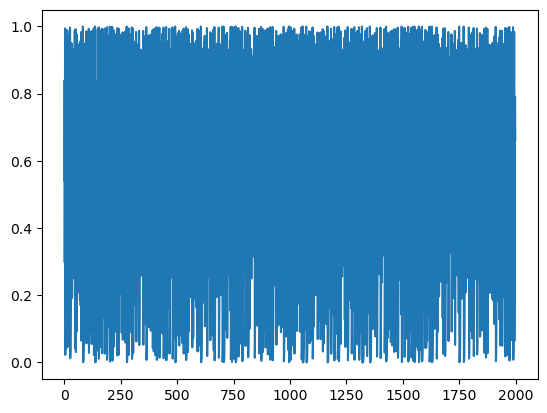

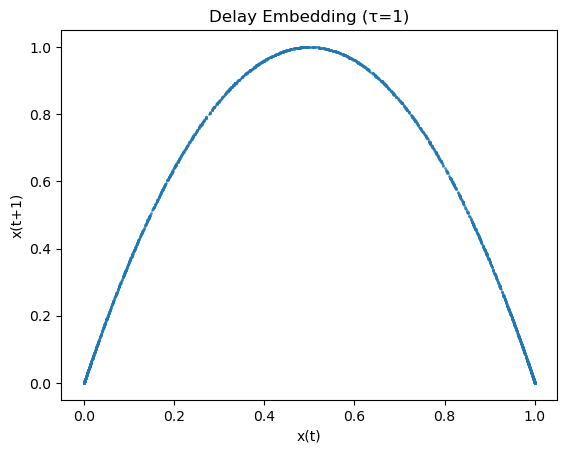

0.34909543


In [12]:
mu, sig = 0, 0.02
N = 2000
lgm = logistic_map(4.0, 0.3, N)

plt.plot(lgm)
plt.show()

plot_delay(lgm, 1)

print(np.std(lgm))

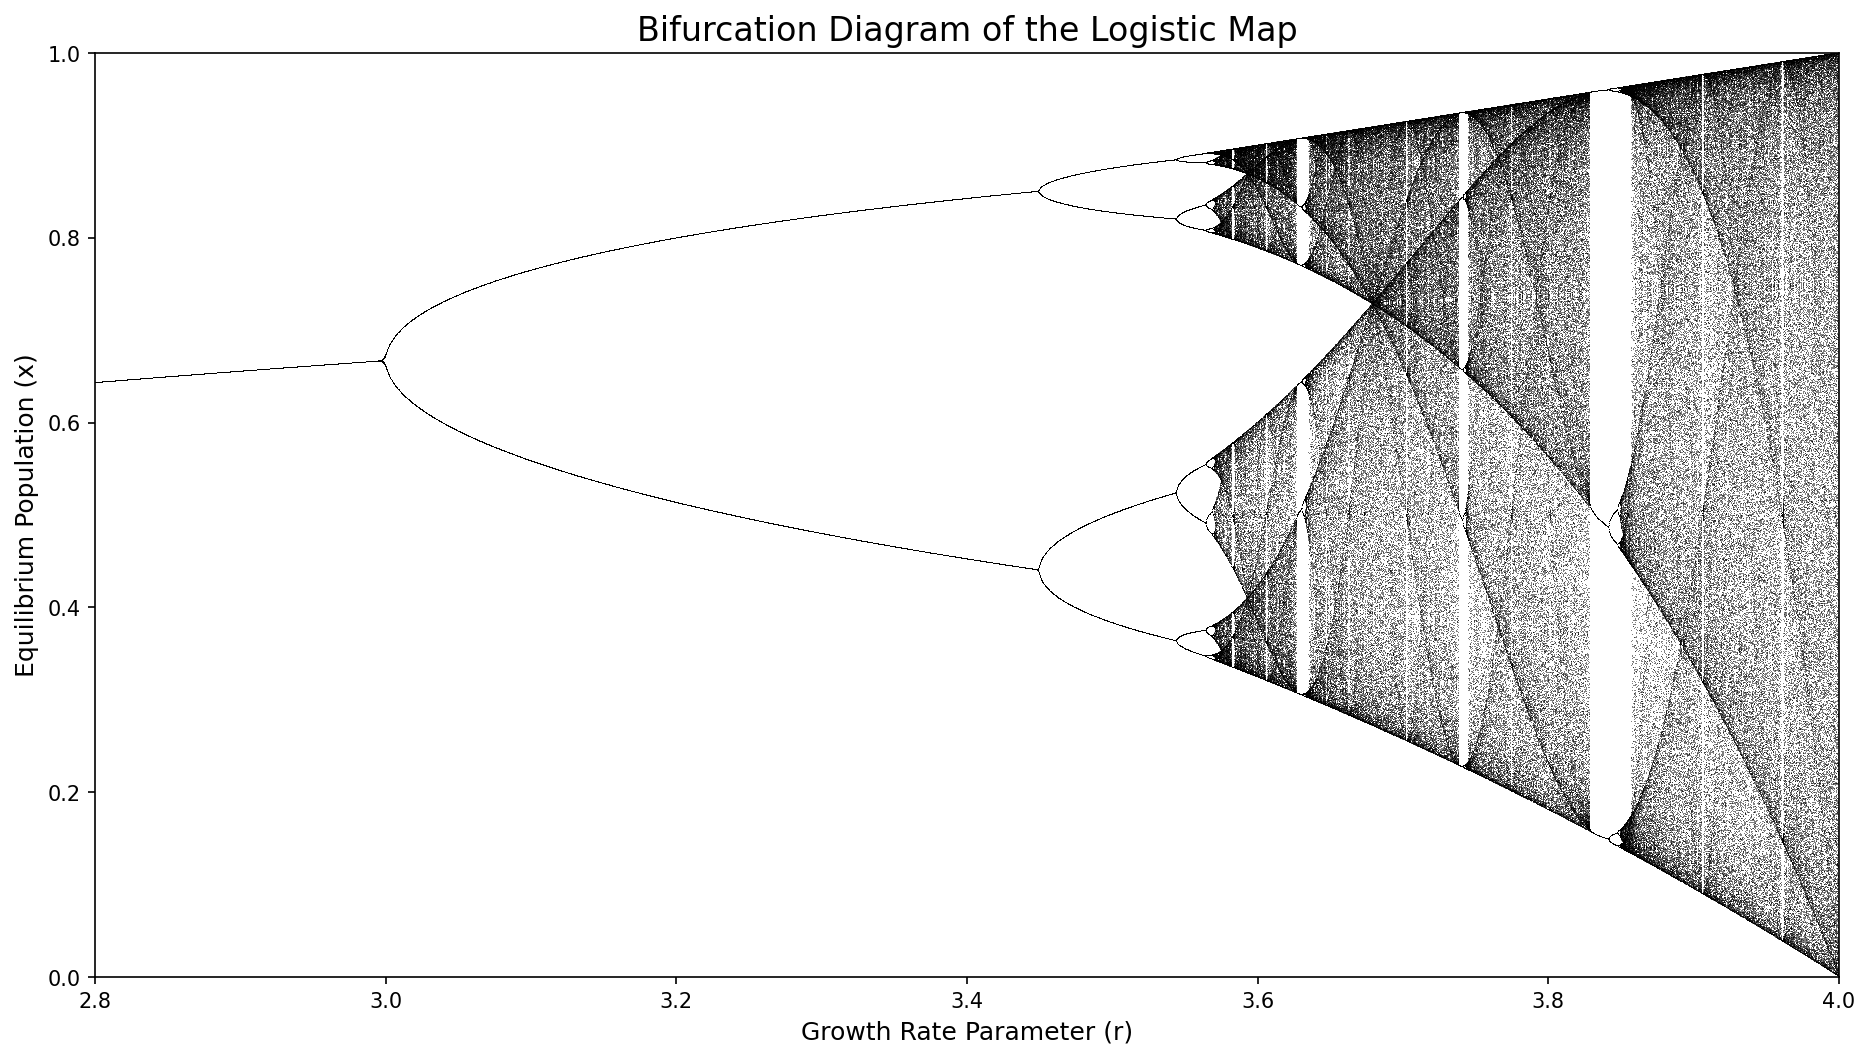

In [13]:
plot_bifur_logistic(np.linspace(2.8, 4.0, 5000))

In [14]:
# range_r = (3.4, 4.0)
# num_r = 100
# r_values = np.linspace(range_r[0], range_r[1], num_r)

# entropy_list = []
# for val in r_values: 
#     data = logistic_map(val, 0.2, 200)
#     radius = 0.1 * np.std(data)
#     entropy_list.append(approx_entropy(data, 1, 2, radius))

# plt.plot(r_values, entropy_list)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


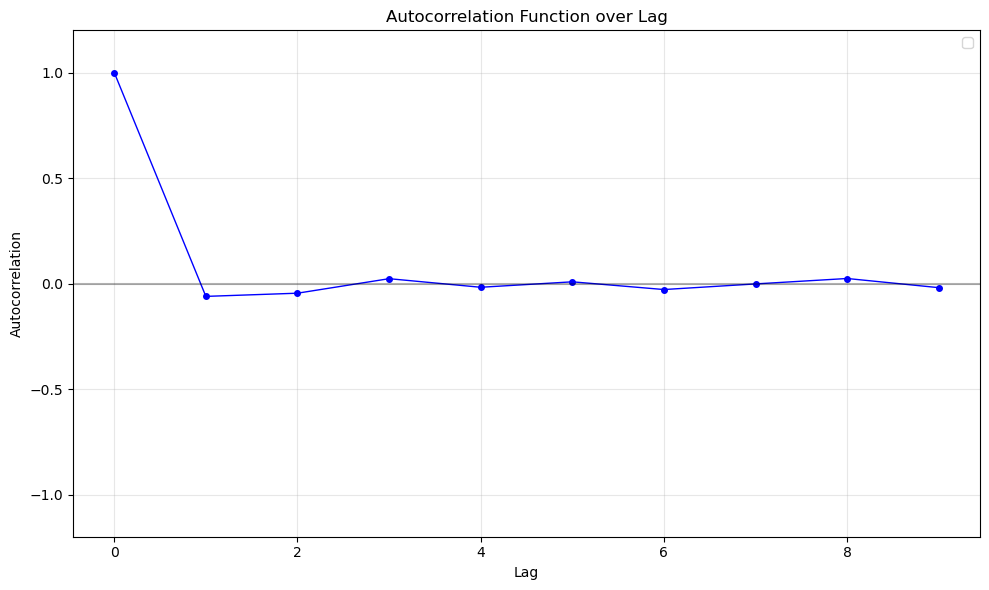

[1.0,
 -0.060946253078538404,
 -0.045826187069656646,
 0.0229407519703313,
 -0.017718719426153176,
 0.008090424668584721,
 -0.028505724584660323,
 -0.0018370428460934261,
 0.023828432279581417,
 -0.019547766501821745]

In [15]:
plot_acf(lgm, 10)

In [16]:
dim, delay = 20, 1
lgm_embedded = delay_embed(lgm, dim, delay)
lgm_delaypca, pca_lgm = delayPCA(lgm, dim, delay, dim)

lgm_pca_recon_loss = calculate_pca_loss_to_dim(lgm_embedded, pca_lgm, 2, dim)
lgm_pca_feature_loss = calculate_pca_feature_loss_to_dim(lgm_embedded, pca_lgm, 2, dim)

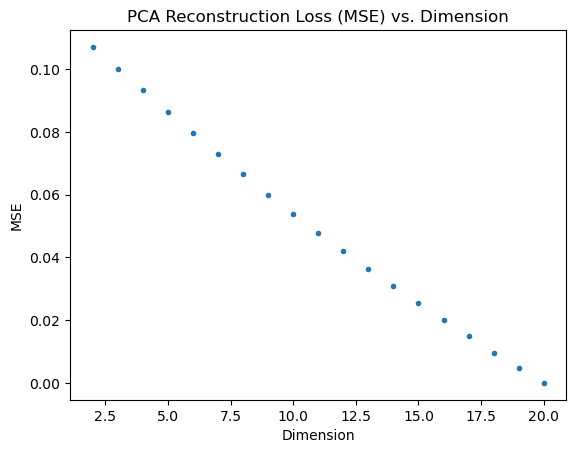

In [17]:
plot_pca_recon_loss(lgm_embedded, pca_lgm, 2, dim)

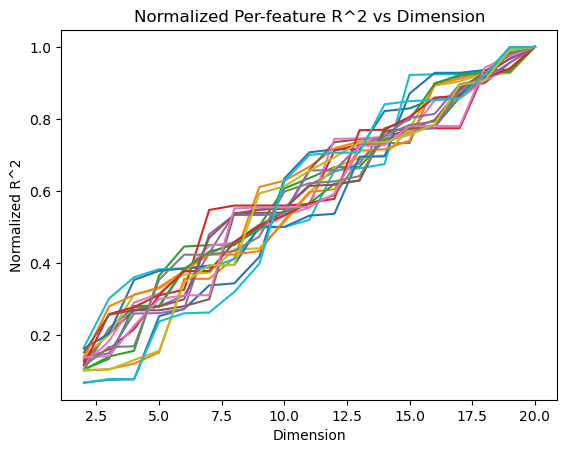

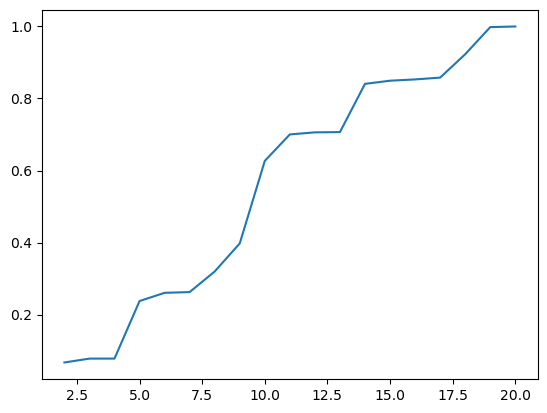

In [18]:
k_feat = 19

plt.title("Normalized Per-feature R^2 vs Dimension")
plt.plot(np.arange(2, dim+1), lgm_pca_feature_loss[:, :20])
plt.xlabel('Dimension')
plt.ylabel('Normalized R^2')
plt.show()

plt.title("")
plt.plot(np.arange(2, dim+1), lgm_pca_feature_loss[:, k_feat])
plt.show()

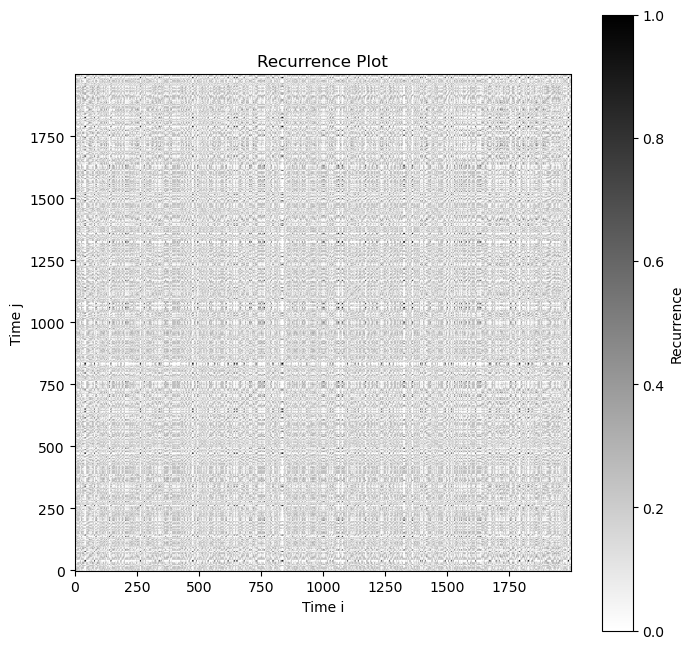

In [19]:
plot_recurrence(lgm, 0.5*np.std(lgm), 2, 1)

### Weierstrass Function 

In [20]:
ts_length = 10000
x_val = np.linspace(-2*np.pi, 4*np.pi, ts_length)
a = 0.87
b = 3.0
max_n = 100

wire = weierstrass(x_val, a, b, max_n) + np.random.normal(0, 0.1, ts_length)

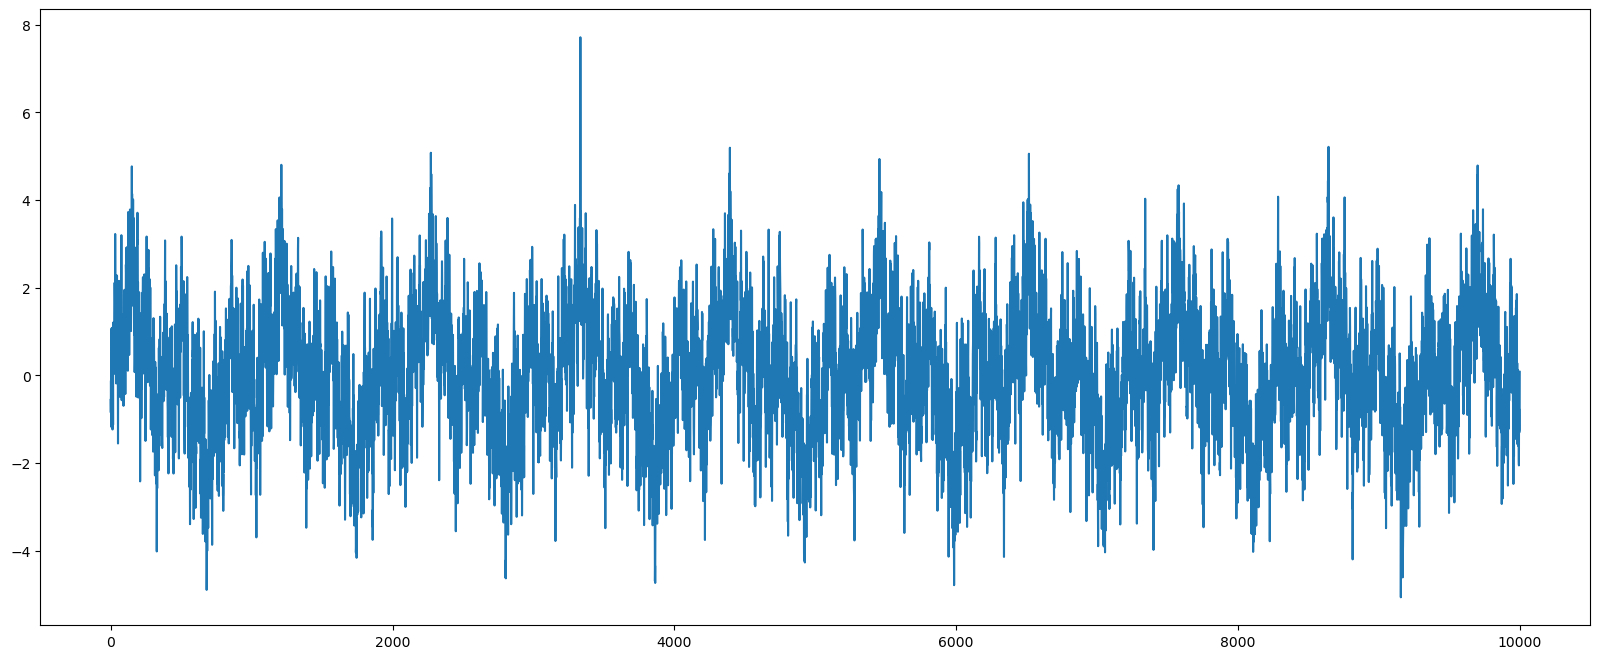

In [21]:
plt.figure(figsize=(20,8))
plt.plot(wire)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


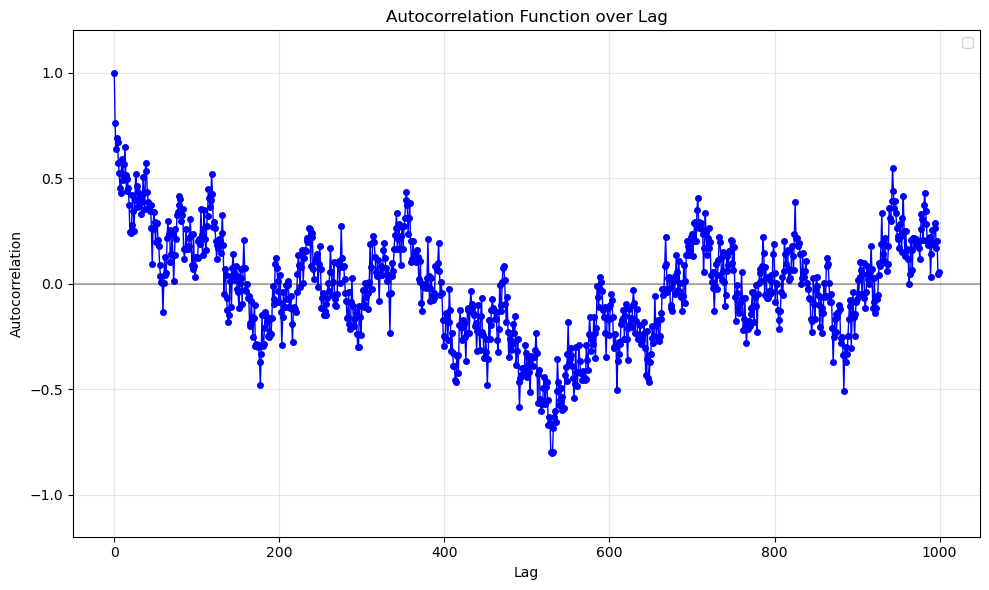

In [22]:
acf_wire = plot_acf(wire, 1000)

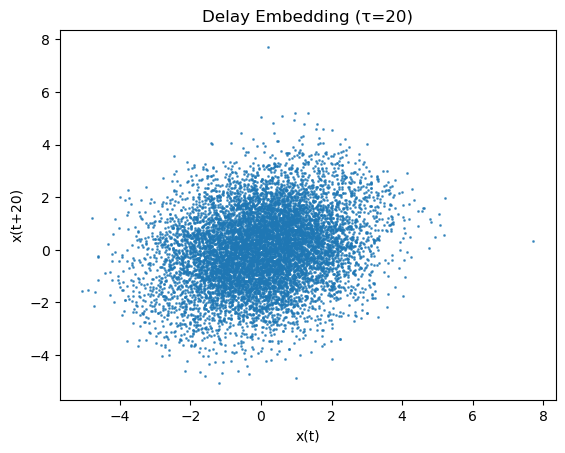

In [23]:
plot_delay(wire, 20)

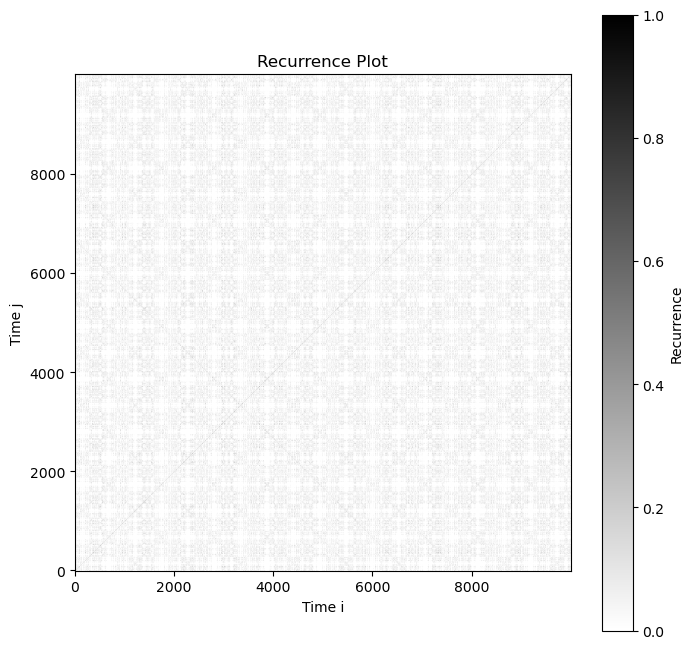

In [24]:
plot_recurrence(wire, 0.3*np.std(wire), 2, 1)

### Mackey-Glass

In [25]:
mgd = mackey_glass_discrete(N=5000, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2)

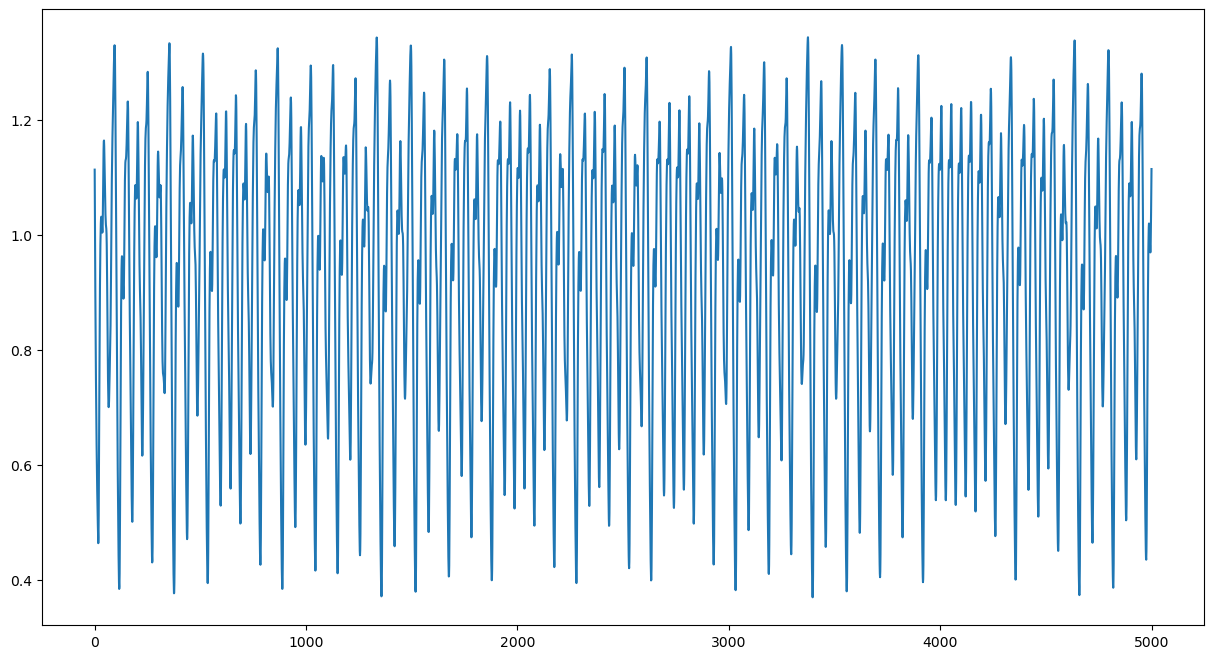

In [26]:
plt.figure(figsize=(15,8))
plt.plot(mgd)
plt.show()

### Laser Map

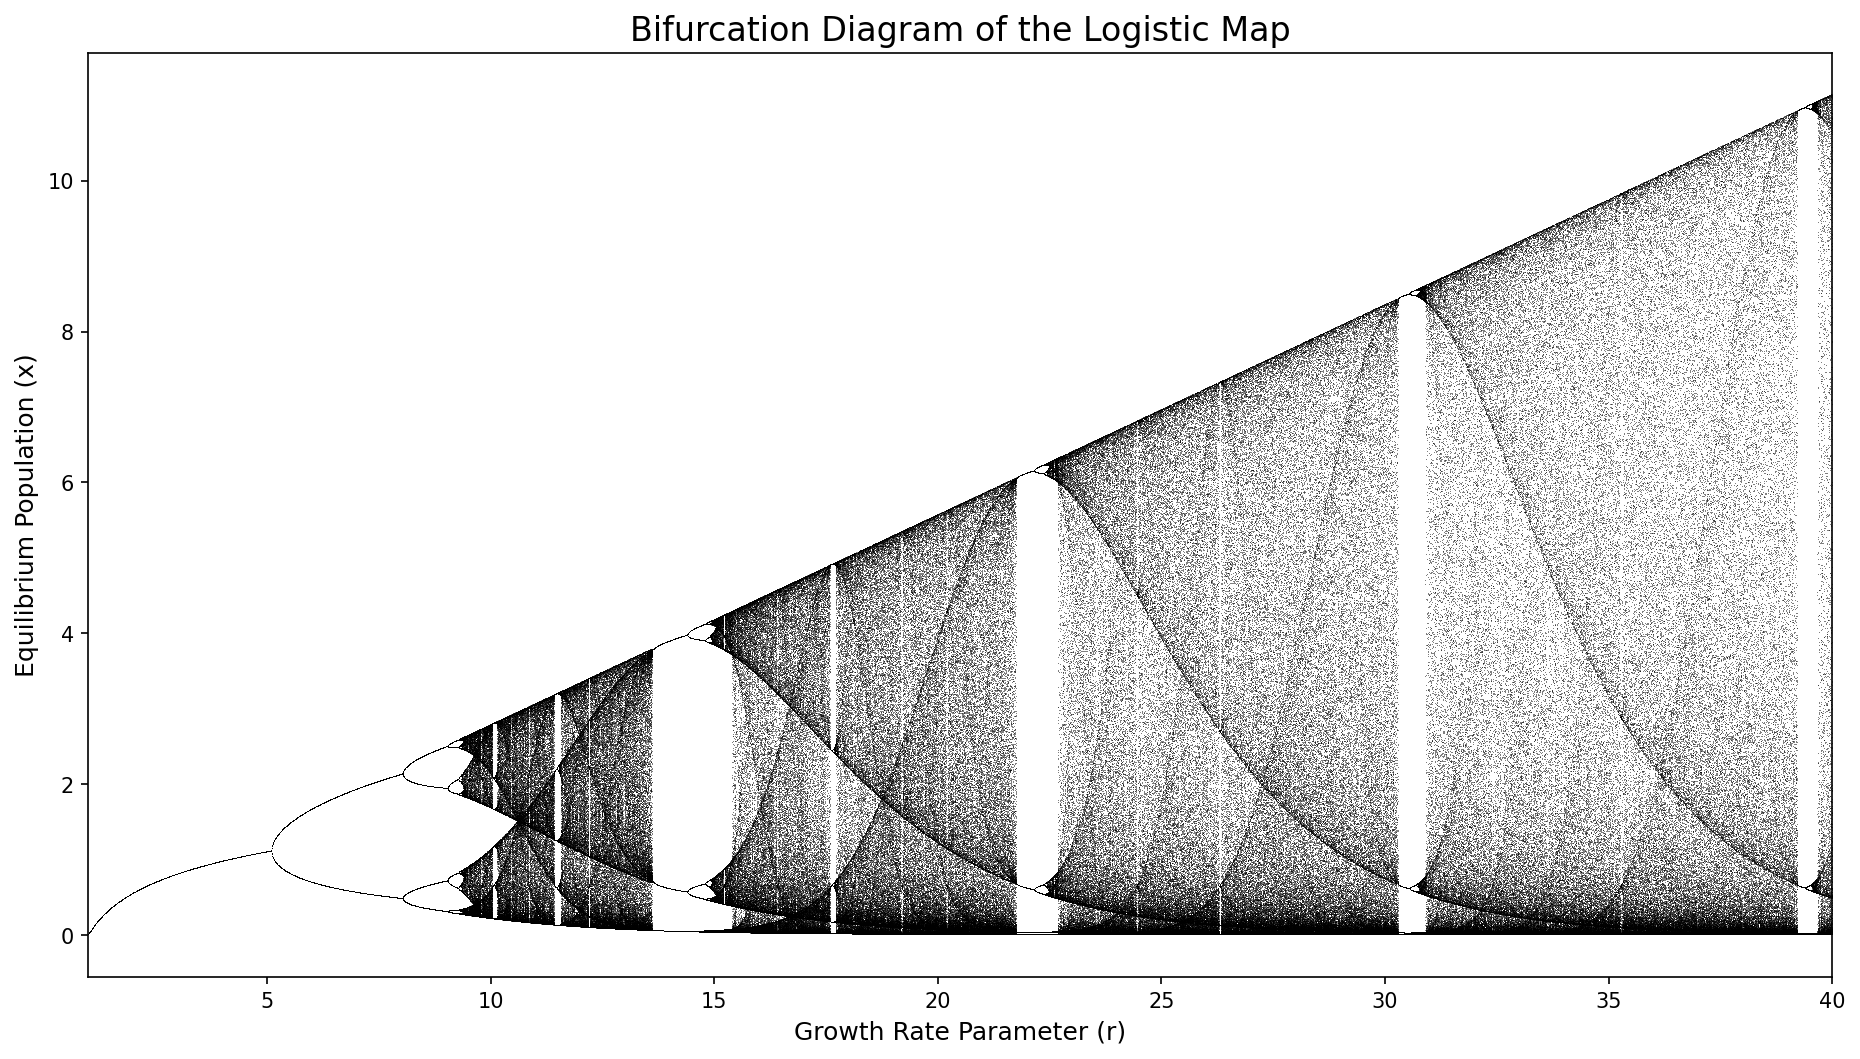

In [27]:
plot_bifur_laser(np.linspace(1, 40, 5000), x0=0.2)

### Lorenz63

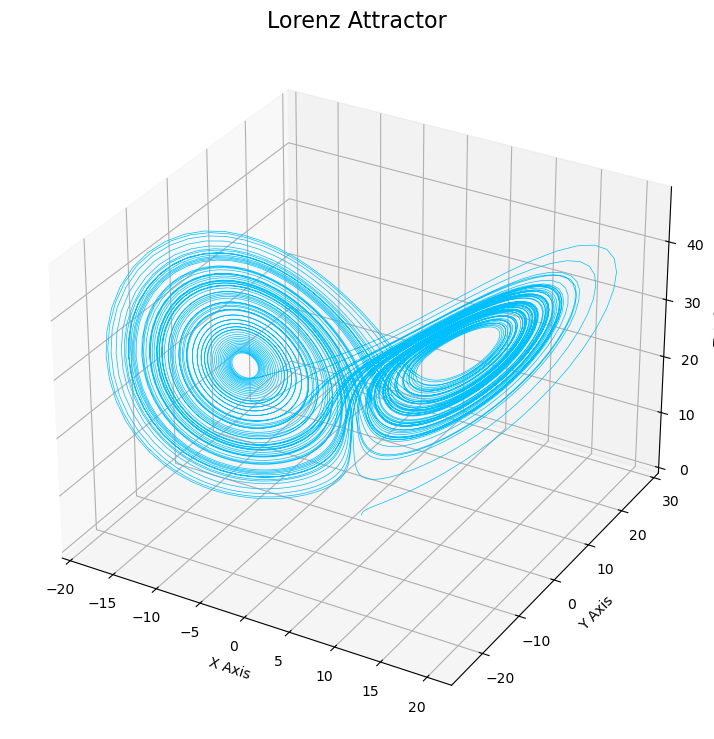

In [28]:
plot_lorenz_attractor(generate_lorenz())

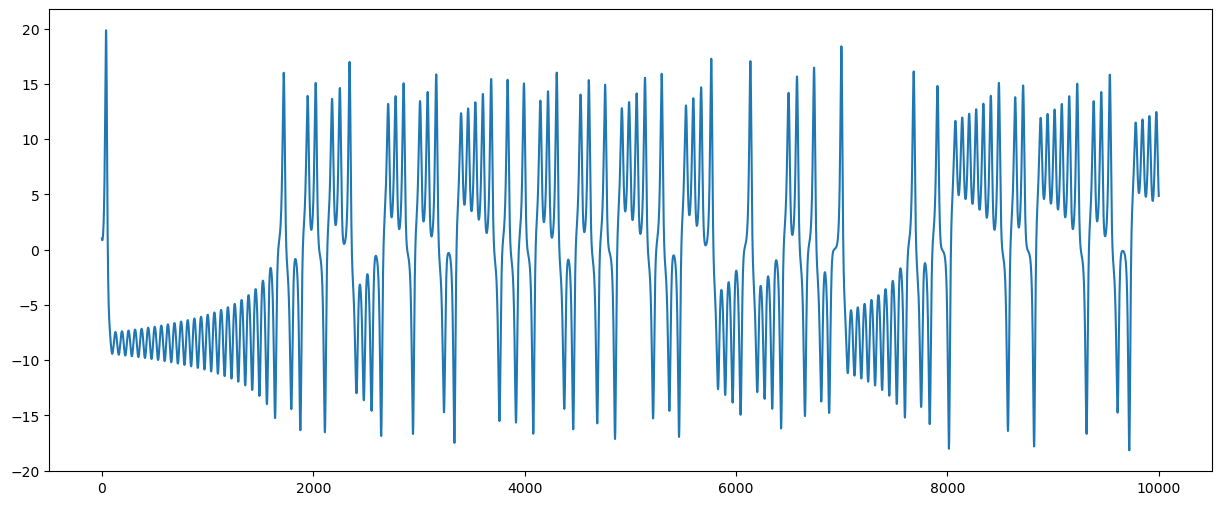

In [29]:
plt.figure(figsize=(15,6))
plt.plot(generate_lorenz()[:, 0])
# plt.plot(lor_y)
# plt.plot(lor_z)
plt.show()

### PCA SUBSPACE TRACKING: Test cross recon loss; take a time series, split it into disjoint subsets, then carry out experiments
### measures system stability or uniformity

In [46]:
lgm_seg1, lgm_seg2 = lgm[:1500], lgm[1500:]

emb_dim, emb_del, pca_dim = 10, 1, 10
seg1_de, pca1 = delayPCA(lgm_seg1, emb_dim, emb_del, pca_dim)
seg2_de, pca2 = delayPCA(lgm_seg2, emb_dim, emb_del, pca_dim)

In [47]:
mse, _, x_hat = pca_cross_recon_loss(delay_embed(lgm_seg2, emb_dim, emb_del), pca2, pca2, pca_dim)
print(mse)

3.3546294932260827e-31


In [48]:
r_vals = np.linspace(3.0, 4.0, 100)
pca_cross_loss_lgm = []
pca_recon_loss_lgm = []

for r in r_vals: 
    data = logistic_map(r, 0.5, 1256)
    seg1, seg2 = data[:1000], data[1000:]
    seg1_emb, pca1 = delayPCA(seg1, emb_dim, emb_del, pca_dim)
    seg2_emb, pca2 = delayPCA(seg2, emb_dim, emb_del, pca_dim)

    mse_cross, _, _ = pca_cross_recon_loss(delay_embed(seg2, emb_dim, emb_del), pca2, pca1, pca_dim)
    mse_reg, _, _ = pca_recon_loss(delay_embed(seg2, emb_dim, emb_del), pca2, pca_dim)

    pca_cross_loss_lgm.append(mse_cross)
    pca_recon_loss_lgm.append(mse_reg)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:559: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/var/folders/k6/p59hn9vn3nl08dp9_ybv466c0000gn/T/ipykernel_74299/2207249370.py:211: RuntimeWarning: divide by zero encountered in divide
  r2 = 1.0 - per_feature/var_j
/var/folders/k6/p59hn9vn3nl08dp9_ybv466c0000gn/T/ipykernel_74299/2207249370.py:211: RuntimeWarning: invalid value encountered in divide
  r2 = 1.0 - per_feature/var_j
/var/folders/k6/p59hn9vn3nl08dp9_ybv466c0000gn/T/ipykernel_74299/2207249370.py:184: RuntimeWarning: invalid value encountered in divide
  r2 = 1.0 - per_feature/var_j


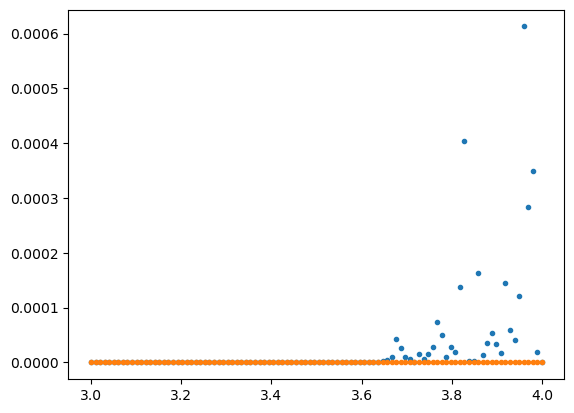

In [49]:
plt.plot(r_vals, pca_cross_loss_lgm, '.')
plt.plot(r_vals, pca_recon_loss_lgm, '.')
plt.show()

### Forecasting Algorithms

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

class TimeSeriesMLP(nn.Module): 
    """ 
        Basic MLP used as a regression model for delay-embedded coordinates
    """
    def __init__(self, lb, latent_dim): 
        super(TimeSeriesMLP, self).__init__()

        layer1 = MLP(lb, latent_dim, lb, nonlinearity='relu')

        self.fnn = layer1

    def forward(self, x): 
        x = self.fnn(x)
        return x

class KoopmanNet(nn.Module):
    """
        Autoencoder-style Koopman operator model.
          encoder: x -> z = phi(x)
          K:       z_next_pred = K z
          decoder: z -> x_hat = psi(z)
        Trains with reconstruction + Koopman consistency in latent space.
    """
    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        enc_hidden=(128, 128),
        dec_hidden=(128, 128),
        activation="relu",
        norm=None,
        dropout=0.0,
        init="xavier",
        bias=True,
        init_scale=0.05,   # range for uniform init of K in [-init_scale, init_scale]
    ):
        super().__init__()

        self.encoder = MLP(
            num_input=input_dim,
            num_hidden=list(enc_hidden),
            num_output=latent_dim,
            nonlinearity=activation,
            norm=norm,
            dropout=dropout,
            out_nonlinearity=None,
            init=init,
            bias=bias,
        )
        self.decoder = MLP(
            num_input=latent_dim,
            num_hidden=list(dec_hidden),
            num_output=input_dim,
            nonlinearity=activation,
            norm=norm,
            dropout=dropout,
            out_nonlinearity=None,
            init=init,
            bias=bias,
        )

        # Koopman operator (shared linear map in latent space)
        self.K = nn.Parameter(torch.empty(latent_dim, latent_dim))
        nn.init.uniform_(self.K, -init_scale, init_scale)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def evolve_latent(self, z, steps=1):
        """
            z_{t+k} = (K^T)^k z_t (since we use row-vectors times weight^T in Linear)
            Here we explicitly multiply by K^T so it's consistent with z @ K.T.
        """
        Kt = self.K.T
        out = z
        for _ in range(steps):
            out = out @ Kt
        return out

    @torch.no_grad()
    def eig(self):
        """
            Returns eigenvalues/vectors of K.
            K V = V diag(λ); columns of V are eigenvectors.
        """
        K_cpu = self.K.detach().cpu()
        vals, vecs = torch.linalg.eig(K_cpu)
        return vals, vecs

    def forward(self, x, x_next=None, steps = 1):
        """
            If x_next is given, also returns z_next_true for loss computation.
            Returns: dict with z, z_next_pred, x_hat, and (optional) z_next_true
        """
        z = self.encode(x)
        z_next_pred = self.evolve_latent(z, steps=steps)
        x_hat = self.decode(z)

        out = {"z": z, "z_next_pred": z_next_pred, "x_hat": x_hat}
        if x_next is not None:
            out["z_next_true"] = self.encode(x_next)
        return out

    def loss_components(
        self,
        x,
        x_next,
        steps = 1,
        alpha_recon = 1.0,
        alpha_koop = 1.0,
        alpha_diag = 0.0,   # off-diagonal L1 penalty (optional)
        reduction: str = "mean",
    ):
        """
            recon: ||x_hat - x||^2
            koop:  ||phi(x_{t+1}) - K^steps phi(x_t)||^2
            diag:  L1 penalty on off-diagonals of K (encourages eigenbasis)
        """
        out = self.forward(x, x_next=x_next, steps=steps)

        recon = F.mse_loss(out["x_hat"], x, reduction=reduction)
        koop  = F.mse_loss(out["z_next_pred"], out["z_next_true"], reduction=reduction)

        if alpha_diag != 0.0:
            K = self.K
            offdiag = K - torch.diag(torch.diag(K))
            diag_pen = offdiag.abs().mean() if reduction == "mean" else offdiag.abs().sum()
        else:
            diag_pen = torch.tensor(0.0, device=x.device)

        total = alpha_recon * recon + alpha_koop * koop + alpha_diag * diag_pen
        return {"total": total, "recon": recon, "koop": koop, "diag_pen": diag_pen, **out}


### Helpers

In [1]:
def create_io_pairs(series):
    """
        Creates input-output pairs (x_t, x_{t+1}) from a time series.
    """
    inputs = series[:-1]
    outputs = series[1:]
    # Reshape to be (num_samples, 1) for a 1D time series
    return inputs.reshape(-1, 1), outputs.reshape(-1, 1)

def create_forecast_set(time_series, lb, step=1): 
    x, y = [], []
    for i in range(0, len(time_series)-lb): 
        feat = time_series[i:i+lb]
        tar = time_series[i+step:i+lb+step]
        x.append(feat)
        y.append(tar)

    return torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y))

def split_timeseries(timeseries, train, test): 
    """
        Split data into train, valid, and test
    """
    N = int(len(timeseries))

    n_train = int(N * train)

    return timeseries[:n_train], timeseries[n_train:]

def split_timeseries_io(inputs, outputs, train_frac=0.8):
    """
        Splits data into training and testing sets.
    """
    n_train = int(len(inputs) * train_frac)
    x_train, x_test = inputs[:n_train], inputs[n_train:]
    y_train, y_test = outputs[:n_train], outputs[n_train:]
    return x_train, y_train, x_test, y_test

In [77]:
def Train(model, dataloader, optimizer, criterion=nn.MSELoss(), device='cpu', epochs=100):
    """
        A simple training loop for the MLP model.
    """
    model.train()
    loss_history = []
    print("Starting training...")
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(x_batch, preds)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    print("Training finished.")
    return loss_history

# def return_de_preds(model, x, y): 
#     """
#         Reverse transformation for delay-embedded prediction. Takes the last element in each block. 
#     """
#     model.eval()
#     with torch.no_grad(): 
#         preds = model(x)

#     out = []
#     for i in range(len(preds)): 
#         out = np.hstack((out, preds[i][-1][-1]))

#     return np.array(out)

def train_koop(model, dataloader, optimizer, device='cpu', epochs=100):
    """
        A simple training loop for the KoopmanNet model.
    """
    model.train()
    loss_history = []
    print("Starting training...")
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            losses = model.loss_components(x_batch, y_batch)
            loss = losses["total"]
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    print("Training finished.")
    return loss_history

def test_koop(model, X_test, y_test, device='cpu'):
    """
        Evaluates the model and returns one-step predictions and losses.
    """
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test).to(device)
        y_test_tensor = torch.from_numpy(y_test).to(device)
        
        losses = model.loss_components(X_test_tensor, y_test_tensor)
        
        # Get one-step predictions
        forward_out = model.forward(X_test_tensor)
        z_next_pred = forward_out['z_next_pred']
        x_next_pred = model.decode(z_next_pred).numpy()

    print("\n--- Test Results ---")
    print(f"Total Loss:  {losses['total'].item():.6f}")
    print(f"Recon Loss:  {losses['recon'].item():.6f}")
    print(f"Koopman Loss: {losses['koop'].item():.6f}")
    
    return x_next_pred

# --- Visualization ---

def plot_results(X_test, y_test, y_pred, loss_history):
    """
        Plots training loss and test predictions.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot training loss
    ax1.plot(loss_history)
    ax1.set_title("Training Loss Over Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Total Loss")

    # Plot test predictions vs. ground truth
    ax2.plot(y_test, label="Ground Truth", marker='.', linestyle='None', color='blue', alpha=0.6)
    ax2.plot(y_pred, label="One-Step Prediction", marker='x', linestyle='None', color='red', alpha=0.6)
    ax2.set_title("Test Set: Predictions vs. Ground Truth")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Value")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_preds(y, y_pred): 
    plt.figure(figsize=(15,6))
    plt.title("Test Data")
    plt.plot(y_pred, '-b.', label="prediction")
    plt.plot(y, '-r.', label="ground truth")
    plt.legend()
    
    plt.show()

def plot_error(y, y_pred, f): 
    """
        plot prediction error computed by f(y, y_pred)
    """
    pred_error = f(y, y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(test_error)
    plt.title("Prediction Error on the Test Set")
    plt.xlabel("Time Step")
    plt.ylabel("Error (True - Predicted)")
    plt.grid(True)
    plt.show()

### Koopman Operator vs. Delay Embedding

In [48]:
from torch.utils.data import Dataset, DataLoader
DATASET = generate_timeseries('logistic', 1000) 

Using Logistic Map dataset.


#### Koopman Operator

In [69]:
LATENT_DIM = 16
EPOCHS = 1000
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

inputs, outputs = create_io_pairs(DATASET)
x_train, y_train, x_test, y_test = split_timeseries_io(inputs, outputs)

# Create PyTorch DataLoaders
train_dataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(x_train.shape)

(799, 1)


Starting training...
Epoch [10/1000], Loss: 0.000551
Epoch [20/1000], Loss: 0.000235
Epoch [30/1000], Loss: 0.000303
Epoch [40/1000], Loss: 0.000196
Epoch [50/1000], Loss: 0.000389
Epoch [60/1000], Loss: 0.000120
Epoch [70/1000], Loss: 0.000100
Epoch [80/1000], Loss: 0.000072
Epoch [90/1000], Loss: 0.000058
Epoch [100/1000], Loss: 0.000048
Epoch [110/1000], Loss: 0.000047
Epoch [120/1000], Loss: 0.000154
Epoch [130/1000], Loss: 0.000025
Epoch [140/1000], Loss: 0.000029
Epoch [150/1000], Loss: 0.000024
Epoch [160/1000], Loss: 0.000019
Epoch [170/1000], Loss: 0.000021
Epoch [180/1000], Loss: 0.000017
Epoch [190/1000], Loss: 0.000042
Epoch [200/1000], Loss: 0.000014
Epoch [210/1000], Loss: 0.000016
Epoch [220/1000], Loss: 0.000014
Epoch [230/1000], Loss: 0.000154
Epoch [240/1000], Loss: 0.000032
Epoch [250/1000], Loss: 0.000012
Epoch [260/1000], Loss: 0.000088
Epoch [270/1000], Loss: 0.000009
Epoch [280/1000], Loss: 0.000008
Epoch [290/1000], Loss: 0.000015
Epoch [300/1000], Loss: 0.00000

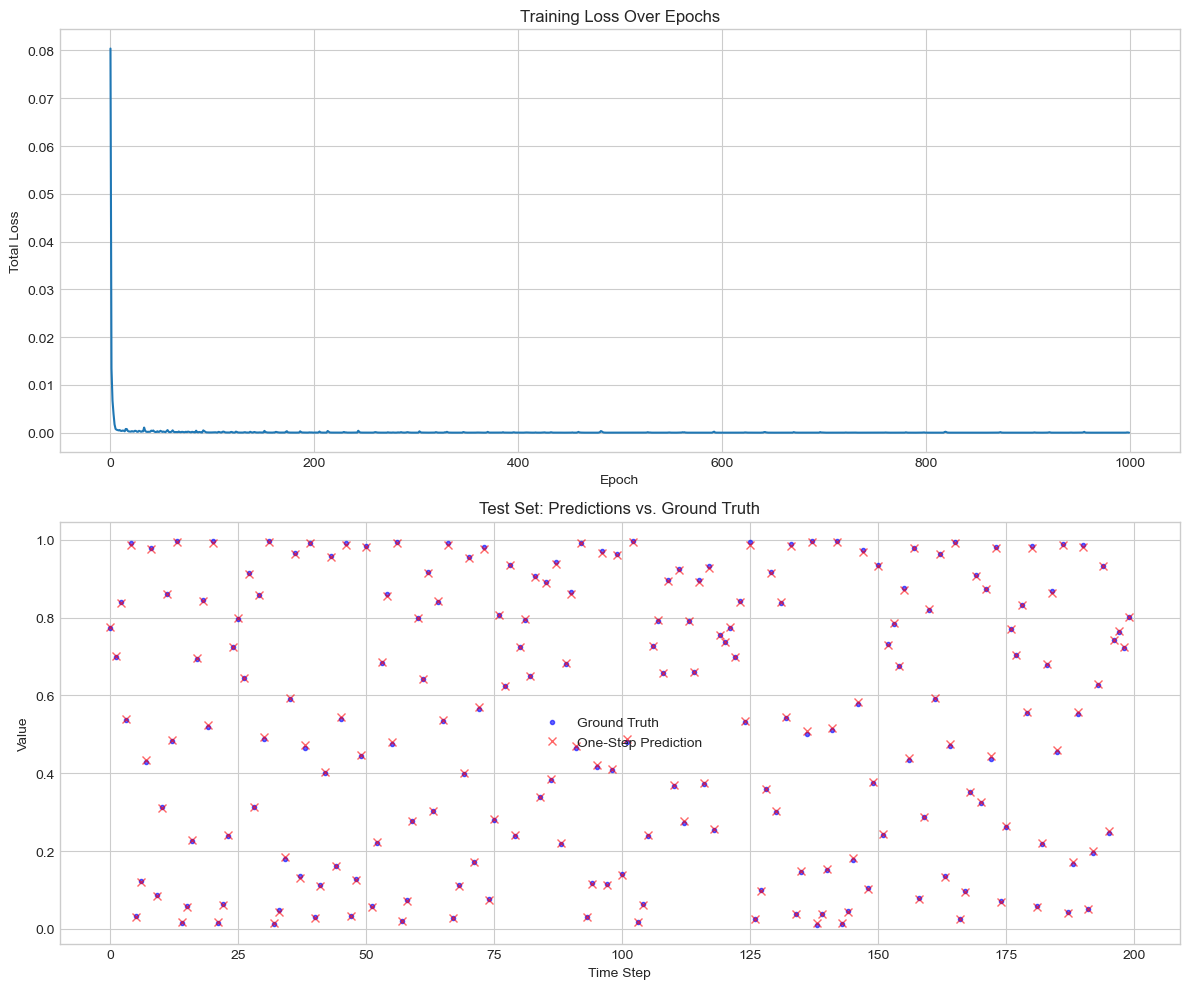

In [72]:
input_dim = x_train.shape[1]
model_koop = KoopmanNet(input_dim=input_dim, latent_dim=LATENT_DIM)
optimizer = torch.optim.Adam(model_koop.parameters(), lr=LEARNING_RATE)

loss_history = train_koop(model_koop, train_loader, optimizer, epochs=EPOCHS)

y_pred = test_koop(model_koop, x_test, y_test)

plot_results(x_test, y_test, y_pred, loss_history)

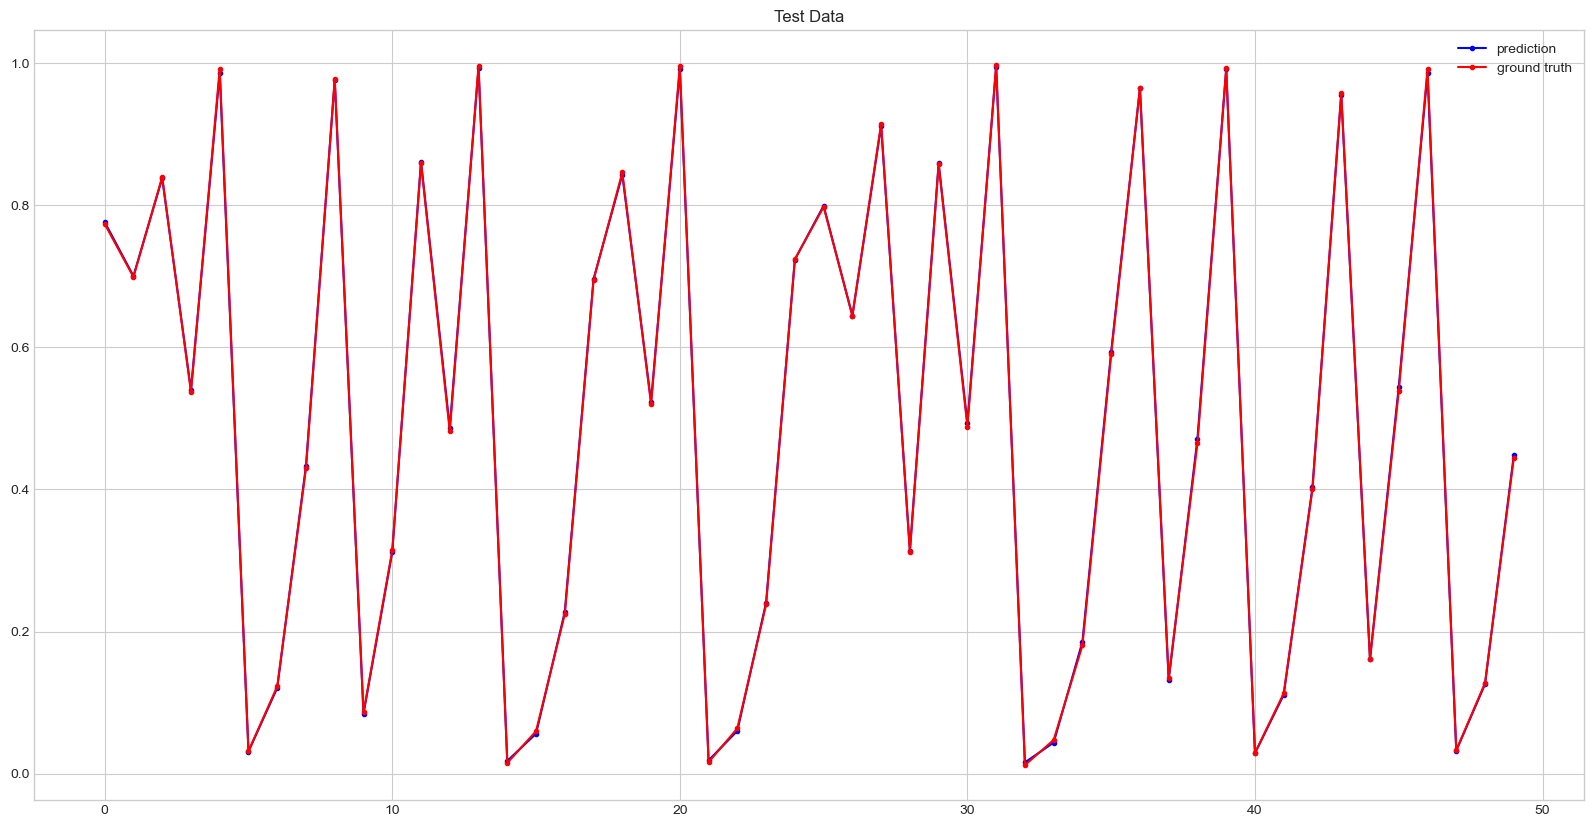

In [73]:
plot_preds(y_test[0:50], y_pred[0:50])

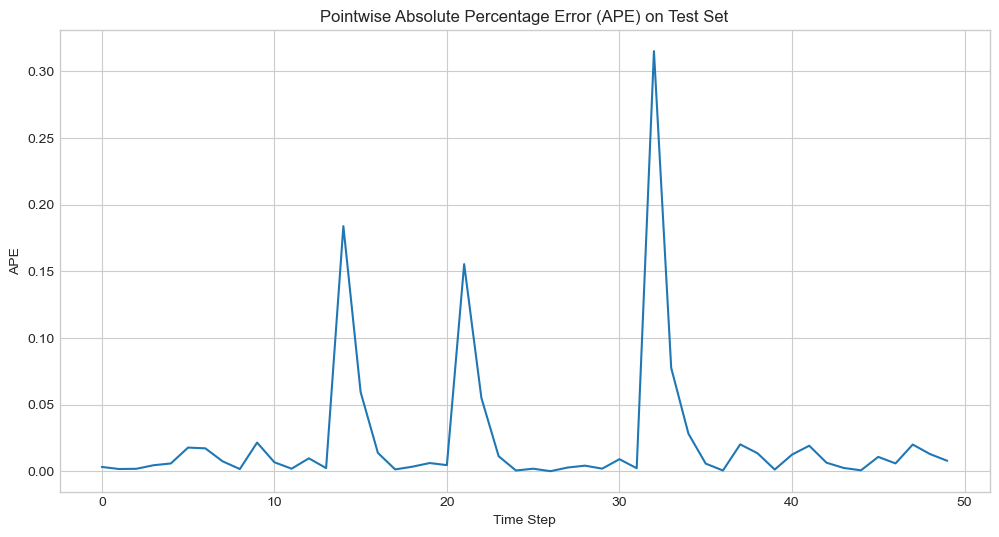

In [74]:
koop_analyzer = PredError(y_test[0:50], y_pred[0:50])
koop_analyzer.plot(error_type='ape')

#### Delay Embedding

somethings not working fix!!!

In [55]:
delay = 1
emb_dim = 2

data = delay_embed(DATASET, emb_dim, delay)

train, test = split_timeseries(data, 0.7, 0.3)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [57]:
print(train.shape)

(699, 2)


In [58]:
model_de = TimeSeriesMLP(lookback, [128]*2)

optimizer_de = torch.optim.Adam(model_de.parameters(), lr=1e-3)

loss_history = Train(model_de, train_loader_de, optimizer_de, epochs=500)

Starting training...
Epoch [10/500], Loss: 0.000004
Epoch [20/500], Loss: 0.000001
Epoch [30/500], Loss: 0.000000
Epoch [40/500], Loss: 0.000000
Epoch [50/500], Loss: 0.000000
Epoch [60/500], Loss: 0.000000
Epoch [70/500], Loss: 0.000000
Epoch [80/500], Loss: 0.000000
Epoch [90/500], Loss: 0.000000
Epoch [100/500], Loss: 0.000000
Epoch [110/500], Loss: 0.000000
Epoch [120/500], Loss: 0.000000
Epoch [130/500], Loss: 0.000000
Epoch [140/500], Loss: 0.000000
Epoch [150/500], Loss: 0.000000
Epoch [160/500], Loss: 0.000000
Epoch [170/500], Loss: 0.000000
Epoch [180/500], Loss: 0.000000
Epoch [190/500], Loss: 0.000003
Epoch [200/500], Loss: 0.000005
Epoch [210/500], Loss: 0.000002
Epoch [220/500], Loss: 0.000002
Epoch [230/500], Loss: 0.000004
Epoch [240/500], Loss: 0.000007
Epoch [250/500], Loss: 0.000002
Epoch [260/500], Loss: 0.000000
Epoch [270/500], Loss: 0.000008
Epoch [280/500], Loss: 0.000002
Epoch [290/500], Loss: 0.000001
Epoch [300/500], Loss: 0.000000
Epoch [310/500], Loss: 0.000

In [64]:
model_de.eval()

preds, true = [], []
with torch.no_grad():
    for input, target in test_loader: 
        output = model(input)
        preds.extend(output[:, -1].numpy())
        true.extend(target[:, -1].numpy())

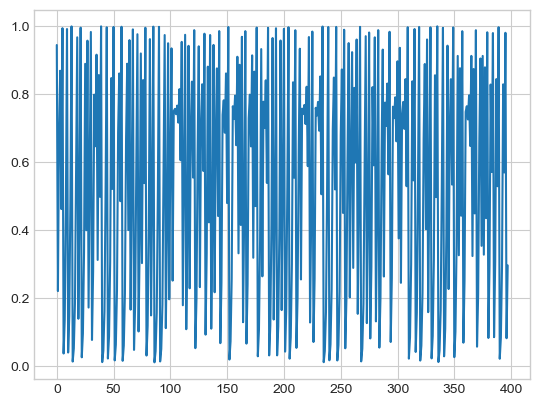

In [65]:
plt.plot(preds)

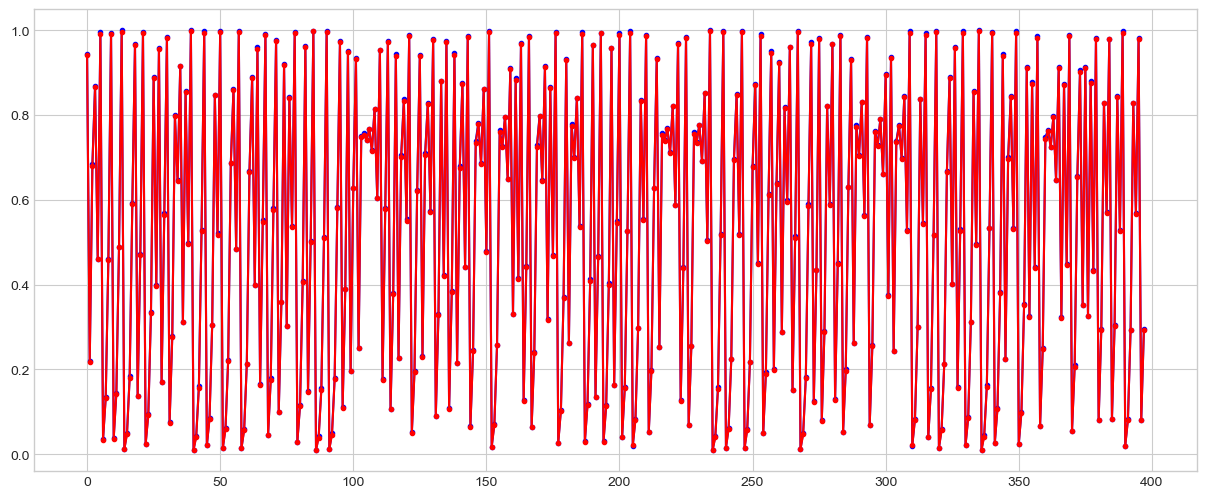

In [68]:
plt.figure(figsize=(15,6))
plt.plot(preds, '-b.')
plt.plot(true, '-r.')
plt.show()